In [ ]:
!pip install flaml[notebook]

     |████████████████████████████████| 139 kB 9.1 MB/s 
     |████████████████████████████████| 2.0 MB 48.2 MB/s 
     |████████████████████████████████| 757 kB 58.1 MB/s 
     |████████████████████████████████| 76.3 MB 61 kB/s 
     |████████████████████████████████| 158 kB 39.0 MB/s 
  Created wheel for openml: filename=openml-0.10.2-py3-none-any.whl size=190318 sha256=015a45246f67d84484d5f894625c4343d2271ae7fbf3522727e7d4b1dc3ddd24
  Stored in directory: /root/.cache/pip/wheels/9c/9e/f3/6a5ebf16527d7fe22d9bc1652bc9beb5dc9fcfdeb75e805400
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11731 sha256=de4165bd04de7b53d6d041807d84fa61381715f8e7c3b67922ae9ed68735a1a0
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-

In [ ]:
!pip install flaml

# Imports

In [ ]:
# common imports
import os
import glob
import random
import numpy as np
import pandas as pd
from scipy.stats import randint

# models libraries
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.svm import SVR
# sklearn imports 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# hyperopt imports to perform bayesian optimisation 
from hyperopt import Trials, anneal, fmin, hp, tpe

''' import AutoML class from flaml package '''
from flaml import AutoML

%matplotlib inline

# 5-6 Dataset

## Data

### Using balanced datasets independently

In [ ]:
df1 = pd.read_csv('5-6_Balanced_Stunting.csv')
df2 = pd.read_csv('5-6_Balanced_Wasting.csv')
df3 = pd.read_csv('5-6_Balanced_Stunted_Wasting.csv')
df1 = df1.drop(['Unnamed: 0'], axis =1)
df2 = df2.drop(['Unnamed: 0'], axis = 1)
df3 = df3.drop(['Unnamed: 0'], axis =1)

In [ ]:
df1

,state,area,religion,caste,type of family,father's education,father's occupation,mother's education,mother's occupation,total family members,exposure to mass media,Source of drinking water,Toilet Facility,mother's age,mother's bmi,child's age,sex of child,birth weight,initiation of bf(early initiation),wealth index,months of bf,history of illness,immunization,index to birth history,no of living children,sex of household head,dietary score,H/A
0,4,0,1,0,1,2,0,2,0,4,1,0,1,3,2,2,1,2,1,1,1,1,2,0,1,1,0,1
1,4,0,2,0,1,3,0,1,0,5,1,0,1,3,0,4,1,2,1,0,1,1,2,0,1,1,0,1
2,4,0,1,1,1,3,0,3,6,6,1,0,0,0,2,6,0,2,1,3,0,1,2,0,1,1,0,0
3,4,0,1,1,1,3,0,3,6,6,1,0,0,0,2,1,1,2,1,3,0,0,0,1,1,1,0,1
4,4,0,0,2,1,1,5,1,6,7,1,1,1,3,0,5,0,2,1,0,0,0,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39046,1,0,1,1,1,3,0,3,6,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
39047,1,1,1,1,1,3,3,3,6,9,1,0,0,0,1,3,0,0,0,4,0,0,0,0,0,1,0,1
39048,1,0,1,2,0,1,0,1,0,2,1,0,0,3,0,4,0,2,0,2,0,0,0,0,1,1,0,1
39049,0,0,1,1,1,3,0,2,6,8,1,1,0,0,0,0,0,1,1,3,0,1,2,0,0,1,0,1


In [ ]:
x1 = df1.drop(['H/A'], axis = 1)
x2 = df2.drop(['W/H'], axis = 1)
x3 = df3.drop(['HAWH'], axis = 1)

In [ ]:
y1 = df1['H/A']
y2 = df2['W/H']
y3 = df3['HAWH']

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=96, stratify = y1)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=103, stratify = y2)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=48, stratify = y3)

### Using unbalanced dependent datasets

In [ ]:
df = pd.read_csv('New_Dataset_5-6.csv')

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,state,area,religion,caste,type of family,father's education,father's occupation,mother's education,mother's occupation,total family members,exposure to mass media,Source of drinking water,Toilet Facility,mother's age,mother's bmi,child's age,sex of child,birth weight,initiation of bf(early initiation),wealth index,months of bf,history of illness,immunization,index to birth history,no of living children,sex of household head,dietary score,H/A,W/A,W/H,Bmi,HAWH
0,0,0,South_India,Rural,Hindu,OBC,2,Primary education,Rgri,Primary education,Rgri,6,Yes,Improved,Unimproved,<20,underweight,24-36,Male,Not Measured,Late initiation,Poorer,>24,1,Partially immunized,1,2,Male,0,1,1,1,0,1
1,1,1,South_India,Rural,Muslim,OBC,2,Secondary education,Rgri,No education,Rgri,7,Yes,Improved,Unimproved,<20,healthy,48-59,Male,Not Measured,Late initiation,Middle,>24,1,Partially immunized,1,2,Male,0,1,0,0,0,0
2,2,2,South_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,8,Yes,Improved,Improved,20-29,underweight,6-12,Female,Not Measured,Late initiation,Richer,<24,1,Partially immunized,1,2,Male,0,0,0,0,0,0
3,3,3,South_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,8,Yes,Improved,Improved,20-29,underweight,18-24,Male,Not Measured,Late initiation,Richer,<24,0,Fully immunized,2,2,Male,0,1,0,0,0,0
4,4,6,South_India,Rural,Christian,SC,2,No education,skilled labour,No education,unemployed,9,Yes,Unimproved,Unimproved,<20,healthy,6-,Female,Not Measured,Late initiation,Middle,<24,0,Partially immunized,1,1,Male,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38054,38054,51550,East_India,Rural,Hindu,Others,2,No education,skilled labour,Secondary education,unemployed,5,Yes,Improved,Improved,<20,underweight,48-59,Female,Not Measured,Late initiation,Poorest,>24,1,Fully immunized,1,1,Male,0,1,1,0,0,0
38055,38055,51551,East_India,Rural,Hindu,Others,1,Primary education,skilled labour,Primary education,unemployed,4,Yes,Improved,Improved,20-29,underweight,48-59,Male,Not Measured,Late initiation,Poorest,<24,0,Fully immunized,1,2,Male,0,1,1,0,0,0
38056,38056,51552,East_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,5,Yes,Improved,Unimproved,<20,healthy,24-36,Female,2.5+,Early initiation,Poorer,>24,0,Fully immunized,1,1,Male,0,1,1,0,0,0
38057,38057,51553,East_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,7,No,Improved,Improved,<20,healthy,36-48,Male,2.5+,Early initiation,Middle,>24,0,Fully immunized,1,3,Male,0,0,0,0,0,0


In [ ]:
def split_X_y(data):
  X = data.drop('H/A',axis = 1)
  X = X.drop('W/A',axis = 1)
  X = X.drop('W/H',axis = 1)
  X = X.drop('Bmi',axis = 1)
  X = X.drop('HAWH', axis = 1)
  y1 = data['W/A']
  y2 = data['H/A']
  y3 = data['W/H']
  y4 = data['Bmi']
  y5 = data['HAWH']
  y1 = y1.to_frame()  # convert y outputs from series to dataframe
  y2 = y2.to_frame()
  y3 = y3.to_frame()
  y4 = y4.to_frame()
  y5 = y5.to_frame()
  print(X.shape, 'X shape')
  print(y1.shape, 'y1 shape')
  print(y2.shape, 'y2 shape')
  print(y3.shape, 'y3 shape')
  print(y4.shape, 'y4 shape')
  print(y5.shape, 'y5 shape')
  return X, y1, y2, y3, y4, y5

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state = 456)

In [ ]:
X_train, y1_train, y2_train, y3_train, y4_train, y5_train = split_X_y(train)

(28544, 27) X shape
(28544, 1) y1 shape
(28544, 1) y2 shape
(28544, 1) y3 shape
(28544, 1) y4 shape
(28544, 1) y5 shape


In [ ]:
X_test, y1_test, y2_test, y3_test, y4_test, y5_test= split_X_y(test)

(9515, 27) X shape
(9515, 1) y1 shape
(9515, 1) y2 shape
(9515, 1) y3 shape
(9515, 1) y4 shape
(9515, 1) y5 shape


In [ ]:
y1_test_np = y1_test.to_numpy()
y2_test_np = y2_test.to_numpy()
y3_test_np = y3_test.to_numpy()
y4_test_np = y4_test.to_numpy()
y5_test_np = y5_test.to_numpy()

In [ ]:
y1_train_np = y1_train.to_numpy()
y2_train_np = y2_train.to_numpy()
y3_train_np = y3_train.to_numpy()
y4_train_np = y4_train.to_numpy()
y5_train_np = y5_train.to_numpy()

## model

In [ ]:
y1_test_np = y1_test.to_numpy()
y2_test_np = y2_test.to_numpy()
y3_test_np = y3_test.to_numpy()

y1_train_np = y1_train.to_numpy()
y2_train_np = y2_train.to_numpy()
y3_train_np = y3_train.to_numpy()

In [ ]:
automl = AutoML()

In [ ]:
automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'accuracy',
    "task": 'classification'
}

### HA

In [ ]:

automl.fit(X_train=x1_train, y_train=y1_train_np,
           **automl_settings)

[flaml.automl: 12-26 11:51:52] {1957} INFO - task = classification
[flaml.automl: 12-26 11:51:52] {1959} INFO - Data split method: stratified
[flaml.automl: 12-26 11:51:52] {1963} INFO - Evaluation method: cv
[flaml.automl: 12-26 11:51:52] {2055} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-26 11:51:52] {2107} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-26 11:51:52] {2347} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-26 11:51:53] {2461} INFO - Estimated sufficient time budget=11044s. Estimated necessary time budget=271s.
[flaml.automl: 12-26 11:51:53] {2541} INFO -  at 1.6s,	estimator lgbm's best error=0.3789,	best estimator lgbm's best error=0.3789
[flaml.automl: 12-26 11:51:53] {2347} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-26 11:51:54] {2541} INFO -  at 2.7s,	estimator lgbm's best error=0.3789,	best estimator lgbm's best error=0.3789
[flaml.a

In [ ]:
def create_auc_roc(y1_test_np, automl, x_test):
  from sklearn.metrics import roc_curve, roc_auc_score
  from matplotlib import pyplot as plt
  preds = automl.predict(x_test).reshape(-1, 1)
  ns_probs = np.array([0 for _ in range(len(y1_test_np))]).reshape(-1, 1)
  print(ns_probs.shape)
  ns_auc = roc_auc_score(y1_test_np, ns_probs)
  lr_auc = roc_auc_score(y1_test_np, preds)

  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Trained: ROC AUC=%.3f' % (lr_auc))

  ns_fpr, ns_tpr, _ = roc_curve(y1_test_np, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y1_test_np, preds)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()


(11716, 1)
No Skill: ROC AUC=0.500
Trained: ROC AUC=0.651


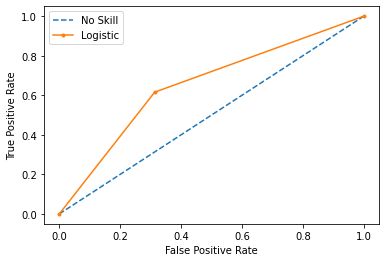

In [ ]:
create_auc_roc(y1_test_np, automl, x1_test)

In [ ]:
print(automl.model)

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 752, 'num_leaves': 37, 'min_child_samples': 6, 'learning_rate': 0.028770723567839638, 'log_max_bin': 8, 'colsample_bytree': 0.5008105465381789, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.038898649078675136}
Best accuracy on validation data: 0.6539
Training duration of best run: 4.66 s


### W/H

In [ ]:

automl.fit(X_train=x2_train, y_train=y2_train_np,
           **automl_settings)
# Export the best model


[flaml.automl: 12-26 12:19:36] {1957} INFO - task = classification
[flaml.automl: 12-26 12:19:36] {1959} INFO - Data split method: stratified
[flaml.automl: 12-26 12:19:36] {1963} INFO - Evaluation method: cv
[flaml.automl: 12-26 12:19:36] {2055} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-26 12:19:36] {2107} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-26 12:19:36] {2347} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-26 12:19:39] {2461} INFO - Estimated sufficient time budget=23002s. Estimated necessary time budget=565s.
[flaml.automl: 12-26 12:19:39] {2541} INFO -  at 3.0s,	estimator lgbm's best error=0.3983,	best estimator lgbm's best error=0.3983
[flaml.automl: 12-26 12:19:39] {2347} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-26 12:19:40] {2541} INFO -  at 4.1s,	estimator lgbm's best error=0.3983,	best estimator lgbm's best error=0.3983
[flaml.a

(18250, 1)
No Skill: ROC AUC=0.500
Trained: ROC AUC=0.846


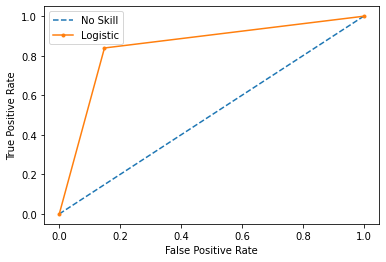

In [ ]:
create_auc_roc(y2_test_np, automl, x2_test)

In [ ]:
print(automl.model)

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 186, 'num_leaves': 1099, 'min_child_samples': 5, 'learning_rate': 0.11621588299658563, 'log_max_bin': 9, 'colsample_bytree': 0.4676132458366714, 'reg_alpha': 0.0024686655398856224, 'reg_lambda': 0.0028201449346997825}
Best accuracy on validation data: 0.8329
Training duration of best run: 7.904 s


### HAWH

In [ ]:

automl.fit(X_train=x3_train, y_train=y3_train_np,
           **automl_settings)
# print(automl.predict_proba(X_train).shape)
# Export the best model
print(automl.model)

[flaml.automl: 12-26 12:46:58] {1957} INFO - task = classification
[flaml.automl: 12-26 12:46:58] {1959} INFO - Data split method: stratified
[flaml.automl: 12-26 12:46:58] {1963} INFO - Evaluation method: cv
[flaml.automl: 12-26 12:46:58] {2055} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-26 12:46:58] {2107} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-26 12:46:58] {2347} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-26 12:47:01] {2461} INFO - Estimated sufficient time budget=22996s. Estimated necessary time budget=565s.
[flaml.automl: 12-26 12:47:01] {2541} INFO -  at 3.1s,	estimator lgbm's best error=0.3175,	best estimator lgbm's best error=0.3175
[flaml.automl: 12-26 12:47:01] {2347} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-26 12:47:01] {2541} INFO -  at 3.9s,	estimator lgbm's best error=0.3175,	best estimator lgbm's best error=0.3175
[flaml.a

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 186, 'num_leaves': 1099, 'min_child_samples': 2, 'learning_rate': 0.11621588299658571, 'log_max_bin': 9, 'colsample_bytree': 0.4676132458366714, 'reg_alpha': 0.002468665539885623, 'reg_lambda': 0.0028201449346997825}
Best accuracy on validation data: 0.9349
Training duration of best run: 8.4 s


(20848, 1)
No Skill: ROC AUC=0.500
Trained: ROC AUC=0.940


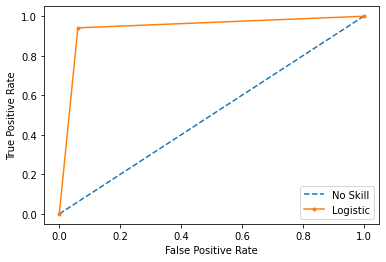

In [ ]:
create_auc_roc(y3_test_np, automl, x3_test)

# 15-16 Dataset

## Data

### Using balanced datasets independently

In [ ]:
df1 = pd.read_csv('15-16_Balanced_Stunting.csv')
df2 = pd.read_csv('15-16_Balanced_Wasting.csv')
df3 = pd.read_csv('15-16_Balanced_Stunted_Wasting.csv')
df1 = df1.drop(['Unnamed: 0'], axis =1)
df2 = df2.drop(['Unnamed: 0'], axis = 1)
df3 = df3.drop(['Unnamed: 0'], axis =1)

In [ ]:
df1

,State,Area,Religion,caste,mothers education,source of water,toilet facility,no of members,no of living children,mothers age(at first birth),sex of household head,wealth index,initiaion of bf,sex of child,months of bf,mothers bmi,child's age,index to birth history,birth weight,history of illness,Exposure to mass media,dietary score,immunization,H/A
0,1,1,1,1,3,0,0,2,0,0,1,3,0,0,1,0,4,0,0,1,1,0,0,0
1,1,1,1,0,0,0,0,1,0,0,1,3,1,0,0,1,2,0,0,0,1,0,0,0
2,1,0,0,3,3,0,0,4,1,0,1,0,0,0,0,0,5,0,0,0,1,4,2,0
3,1,0,0,3,3,0,0,4,2,0,1,4,0,1,0,0,6,0,0,0,1,3,2,0
4,1,0,0,3,3,0,0,3,1,0,0,0,0,0,0,0,2,0,0,0,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226310,4,0,2,1,3,0,0,3,2,0,1,3,0,0,0,0,2,0,0,0,1,0,0,1
226311,4,0,0,2,3,0,0,3,0,0,1,0,0,0,1,0,2,0,0,0,1,0,0,1
226312,4,0,1,0,2,0,1,2,1,3,0,0,0,1,1,0,3,0,0,0,1,0,0,1
226313,3,1,2,0,2,0,0,4,0,3,1,3,0,0,0,0,0,0,0,1,1,3,1,1


In [ ]:
x1 = df1.drop(['H/A'], axis = 1)
x2 = df2.drop(['W/H'], axis = 1)
x3 = df3.drop(['HAWH'], axis = 1)

In [ ]:
y1 = df1['H/A']
y2 = df2['W/H']
y3 = df3['HAWH']

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=96, stratify = y1)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.3, random_state=103, stratify = y2)
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.3, random_state=48, stratify = y3)

### Using unbalanced dependent datasets

In [ ]:
df = pd.read_csv('New_Dataset_5-6.csv')

In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,state,area,religion,caste,type of family,father's education,father's occupation,mother's education,mother's occupation,total family members,exposure to mass media,Source of drinking water,Toilet Facility,mother's age,mother's bmi,child's age,sex of child,birth weight,initiation of bf(early initiation),wealth index,months of bf,history of illness,immunization,index to birth history,no of living children,sex of household head,dietary score,H/A,W/A,W/H,Bmi,HAWH
0,0,0,South_India,Rural,Hindu,OBC,2,Primary education,Rgri,Primary education,Rgri,6,Yes,Improved,Unimproved,<20,underweight,24-36,Male,Not Measured,Late initiation,Poorer,>24,1,Partially immunized,1,2,Male,0,1,1,1,0,1
1,1,1,South_India,Rural,Muslim,OBC,2,Secondary education,Rgri,No education,Rgri,7,Yes,Improved,Unimproved,<20,healthy,48-59,Male,Not Measured,Late initiation,Middle,>24,1,Partially immunized,1,2,Male,0,1,0,0,0,0
2,2,2,South_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,8,Yes,Improved,Improved,20-29,underweight,6-12,Female,Not Measured,Late initiation,Richer,<24,1,Partially immunized,1,2,Male,0,0,0,0,0,0
3,3,3,South_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,8,Yes,Improved,Improved,20-29,underweight,18-24,Male,Not Measured,Late initiation,Richer,<24,0,Fully immunized,2,2,Male,0,1,0,0,0,0
4,4,6,South_India,Rural,Christian,SC,2,No education,skilled labour,No education,unemployed,9,Yes,Unimproved,Unimproved,<20,healthy,6-,Female,Not Measured,Late initiation,Middle,<24,0,Partially immunized,1,1,Male,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38054,38054,51550,East_India,Rural,Hindu,Others,2,No education,skilled labour,Secondary education,unemployed,5,Yes,Improved,Improved,<20,underweight,48-59,Female,Not Measured,Late initiation,Poorest,>24,1,Fully immunized,1,1,Male,0,1,1,0,0,0
38055,38055,51551,East_India,Rural,Hindu,Others,1,Primary education,skilled labour,Primary education,unemployed,4,Yes,Improved,Improved,20-29,underweight,48-59,Male,Not Measured,Late initiation,Poorest,<24,0,Fully immunized,1,2,Male,0,1,1,0,0,0
38056,38056,51552,East_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,5,Yes,Improved,Unimproved,<20,healthy,24-36,Female,2.5+,Early initiation,Poorer,>24,0,Fully immunized,1,1,Male,0,1,1,0,0,0
38057,38057,51553,East_India,Rural,Hindu,Others,2,Secondary education,Rgri,Secondary education,unemployed,7,No,Improved,Improved,<20,healthy,36-48,Male,2.5+,Early initiation,Middle,>24,0,Fully immunized,1,3,Male,0,0,0,0,0,0


In [ ]:
def split_X_y(data):
  X = data.drop('H/A',axis = 1)
  X = X.drop('W/A',axis = 1)
  X = X.drop('W/H',axis = 1)
  X = X.drop('Bmi',axis = 1)
  X = X.drop('HAWH', axis = 1)
  y1 = data['W/A']
  y2 = data['H/A']
  y3 = data['W/H']
  y4 = data['Bmi']
  y5 = data['HAWH']
  y1 = y1.to_frame()  # convert y outputs from series to dataframe
  y2 = y2.to_frame()
  y3 = y3.to_frame()
  y4 = y4.to_frame()
  y5 = y5.to_frame()
  print(X.shape, 'X shape')
  print(y1.shape, 'y1 shape')
  print(y2.shape, 'y2 shape')
  print(y3.shape, 'y3 shape')
  print(y4.shape, 'y4 shape')
  print(y5.shape, 'y5 shape')
  return X, y1, y2, y3, y4, y5

In [ ]:
train, test = train_test_split(df, test_size=0.25, random_state = 456)

In [ ]:
X_train, y1_train, y2_train, y3_train, y4_train, y5_train = split_X_y(train)

(28544, 29) X shape
(28544, 1) y1 shape
(28544, 1) y2 shape
(28544, 1) y3 shape
(28544, 1) y4 shape
(28544, 1) y5 shape


In [ ]:
X_test, y1_test, y2_test, y3_test, y4_test, y5_test= split_X_y(test)

(9515, 29) X shape
(9515, 1) y1 shape
(9515, 1) y2 shape
(9515, 1) y3 shape
(9515, 1) y4 shape
(9515, 1) y5 shape


In [ ]:
y1_test_np = y1_test.to_numpy()
y2_test_np = y2_test.to_numpy()
y3_test_np = y3_test.to_numpy()
y4_test_np = y4_test.to_numpy()
y5_test_np = y5_test.to_numpy()

In [ ]:
y1_train_np = y1_train.to_numpy()
y2_train_np = y2_train.to_numpy()
y3_train_np = y3_train.to_numpy()
y4_train_np = y4_train.to_numpy()
y5_train_np = y5_train.to_numpy()

## model

In [ ]:
y1_test_np = y1_test.to_numpy()
y2_test_np = y2_test.to_numpy()
y3_test_np = y3_test.to_numpy()

y1_train_np = y1_train.to_numpy()
y2_train_np = y2_train.to_numpy()
y3_train_np = y3_train.to_numpy()

In [ ]:
automl = AutoML()

In [ ]:
automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'accuracy',
    "task": 'classification'
}

### HA

In [ ]:

automl.fit(X_train=x1_train, y_train=y1_train_np,
           **automl_settings)

[flaml.automl: 12-26 13:27:14] {1957} INFO - task = classification
[flaml.automl: 12-26 13:27:14] {1959} INFO - Data split method: stratified
[flaml.automl: 12-26 13:27:14] {1963} INFO - Evaluation method: holdout
[flaml.automl: 12-26 13:27:14] {2055} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-26 13:27:14] {2107} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-26 13:27:14] {2347} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-26 13:27:14] {2461} INFO - Estimated sufficient time budget=6886s. Estimated necessary time budget=169s.
[flaml.automl: 12-26 13:27:14] {2541} INFO -  at 1.4s,	estimator lgbm's best error=0.3931,	best estimator lgbm's best error=0.3931
[flaml.automl: 12-26 13:27:14] {2347} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-26 13:27:14] {2541} INFO -  at 1.5s,	estimator lgbm's best error=0.3931,	best estimator lgbm's best error=0.3931
[fla

In [ ]:
def create_auc_roc(y1_test_np, automl, x_test):
  from sklearn.metrics import roc_curve, roc_auc_score
  from matplotlib import pyplot as plt
  preds = automl.predict(x_test).reshape(-1, 1)
  ns_probs = np.array([0 for _ in range(len(y1_test_np))]).reshape(-1, 1)
  print(ns_probs.shape)
  ns_auc = roc_auc_score(y1_test_np, ns_probs)
  lr_auc = roc_auc_score(y1_test_np, preds)

  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print('Trained: ROC AUC=%.3f' % (lr_auc))

  ns_fpr, ns_tpr, _ = roc_curve(y1_test_np, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y1_test_np, preds)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()


(67895, 1)
No Skill: ROC AUC=0.500
Trained: ROC AUC=0.660


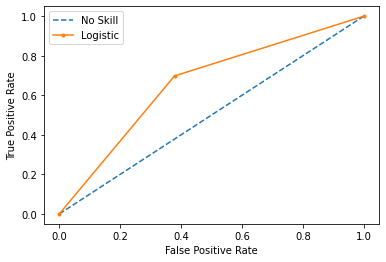

In [ ]:
create_auc_roc(y1_test_np, automl, x1_test)

In [ ]:
print(automl.model)

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgb_limitdepth
Best hyperparmeter config: {'n_estimators': 289, 'max_depth': 12, 'min_child_weight': 17.317952259324176, 'learning_rate': 0.04704558926576879, 'subsample': 0.827351358517848, 'colsample_bylevel': 0.4530063520214701, 'colsample_bytree': 0.6359444321807614, 'reg_alpha': 0.0009765625, 'reg_lambda': 324.4066831726308, 'FLAML_sample_size': 142578}
Best accuracy on validation data: 0.6598
Training duration of best run: 65.14 s


### W/H

In [ ]:

automl.fit(X_train=x2_train, y_train=y2_train_np,
           **automl_settings)
# Export the best model


[flaml.automl: 12-26 13:39:10] {1957} INFO - task = classification
[flaml.automl: 12-26 13:39:10] {1959} INFO - Data split method: stratified
[flaml.automl: 12-26 13:39:10] {1963} INFO - Evaluation method: holdout
[flaml.automl: 12-26 13:39:10] {2055} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-26 13:39:10] {2107} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-26 13:39:10] {2347} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-26 13:39:10] {2461} INFO - Estimated sufficient time budget=8396s. Estimated necessary time budget=206s.
[flaml.automl: 12-26 13:39:10] {2541} INFO -  at 1.6s,	estimator lgbm's best error=0.4283,	best estimator lgbm's best error=0.4283
[flaml.automl: 12-26 13:39:10] {2347} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-26 13:39:10] {2541} INFO -  at 1.7s,	estimator lgbm's best error=0.4283,	best estimator lgbm's best error=0.4283
[fla

(80069, 1)
No Skill: ROC AUC=0.500
Trained: ROC AUC=0.707


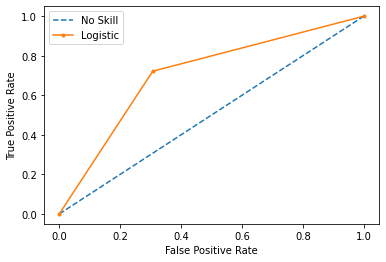

In [ ]:
create_auc_roc(y2_test_np, automl, x2_test)

In [ ]:
print(automl.model)

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgb_limitdepth
Best hyperparmeter config: {'n_estimators': 333, 'max_depth': 7, 'min_child_weight': 2.7720684284418464, 'learning_rate': 0.221794117367674, 'subsample': 1.0, 'colsample_bylevel': 0.6274332478496758, 'colsample_bytree': 0.7722133869187113, 'reg_alpha': 0.0017607866203119683, 'reg_lambda': 0.14322775448429365, 'FLAML_sample_size': 168142}
Best accuracy on validation data: 0.7044
Training duration of best run: 61.86 s


### HAWH

In [ ]:

automl.fit(X_train=x3_train, y_train=y3_train_np,
           **automl_settings)
# print(automl.predict_proba(X_train).shape)
# Export the best model
print(automl.model)

[flaml.automl: 12-26 13:50:14] {1957} INFO - task = classification
[flaml.automl: 12-26 13:50:14] {1959} INFO - Data split method: stratified
[flaml.automl: 12-26 13:50:14] {1963} INFO - Evaluation method: holdout
[flaml.automl: 12-26 13:50:14] {2055} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-26 13:50:14] {2107} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-26 13:50:14] {2347} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-26 13:50:15] {2461} INFO - Estimated sufficient time budget=12279s. Estimated necessary time budget=301s.
[flaml.automl: 12-26 13:50:15] {2541} INFO -  at 2.0s,	estimator lgbm's best error=0.3401,	best estimator lgbm's best error=0.3401
[flaml.automl: 12-26 13:50:15] {2347} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-26 13:50:15] {2541} INFO -  at 2.1s,	estimator lgbm's best error=0.3401,	best estimator lgbm's best error=0.3401
[fl

In [ ]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 9284, 'num_leaves': 1495, 'min_child_samples': 6, 'learning_rate': 0.06911280560506684, 'log_max_bin': 8, 'colsample_bytree': 0.5021054604173047, 'reg_alpha': 0.016684774909953355, 'reg_lambda': 0.14755503297987418, 'FLAML_sample_size': 202990}
Best accuracy on validation data: 0.9253
Training duration of best run: 623.8 s


(96663, 1)
No Skill: ROC AUC=0.500
Trained: ROC AUC=0.935


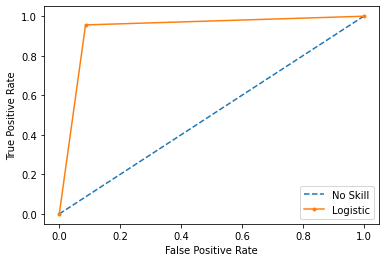

In [ ]:
create_auc_roc(y3_test_np, automl, x3_test)